# Separating plume height into sections for fast exceedance probability estimation

In [ ]:
import os
import sys
import iris

sys.path.append("../pvauncertainty/")
from csv_funs import *
from cubes import *
from plotting import *
from utils import *
from ph_sampling import *

import warnings
warnings.filterwarnings("ignore", category = FutureWarning)
warnings.filterwarnings("ignore", category = RuntimeWarning)

%matplotlib inline

## Uncertainty in the plume height

Suppose we have a height estimate of 12 km asl +/- 2 km, and we want to incorporate this uncertainty in the evaluation of ash concentration threshold exceedance probabilities. Sampling $N$ heights between 10 km and 14 km makes sense, but the computational power and time required to run NAME $N$ times is expensive - especially considering that much of the simulations will be similar. 

A faster way to do this runs NAME once per ensemble member with the release of ash separated into a number of sections. Then, for each plume height sample, we can approximate the resultant ash concentrations and evaluate exceedance probabilities.

In [ ]:
volcano_height = 1725
min_plume_height = 10000
max_plume_height = 14000

In this example we choose a "step size" of 100m for the length of each chunk between 10km and 14km, resuling in 41 separate releases in the same NAME run (40 "chunks" plus one between the vent and the min plume height, which will be included in all samples).

In [ ]:
step_size = 100 # 100 meter steps

this_dir = os.getcwd()
input_dir = this_dir + "../scripts/"
output_dir = this_dir +  "../data/"
csv_file = "ex3.csv"
csv_path = this_dir + "/" + csv_file

chunks = SourceChunks(volcano_height, csv_file, 
                      max_plume_height, min_plume_height,
                      name = "ex3", chunk_lengths = step_size)
chunks.chunk_data

In the following code chunk we set up the NAME runs and execute them. `run_chunks_in_name` will check the output directory for a preexisting NAME setup and if they have already been completed successfully, will not run them again unless `rerun=True`.

**Important note on the input files**: The variables `source_line_no` and `out_line_no` refer to the line numbers of the Source and Output Requirement blocks in `source_file` and `maininput_file`, respectively. 

The code relyies on `%sourcelabel%`, `%sourceheight%`, `%sourcerange%`, `%sourcestrength%` being on line `source_line_no` of `sourcefile`, and `%sourcelabel%` to be in line `out_line_no` of `maininputfile`, because these lines are being copied and pasted in place in case of multiple sources.

In [ ]:
chunks.run_chunks_in_name(
    "ex3", 
    input_dir = "../scripts/",
    output_dir = output_dir,
    ensemble = True,
    source_line_no = 3,
    out_line_no = 109,
    sub_dir = "ex3",
    rerun = False)

### Modelling uncertainty in the plume height

We model uncertainty in the plume height observation by assigning a distribution to it, and incorporate this into the model and resultant exceedance probabilities by integrating over this distribution.

A truncated normal distribution is a disribution derived from that of a normally-distributed random variable by bounding it below and/or above. That is, if $X$ has a normal distribution with mean $\mu$ and variance $\sigma^2$ but lies within an interval $(a,b)$ with $-\infty \leq a < b \leq \infty$, then $X$ conditional on $a < X < b$ has a truncated normal distribution.

Begin by intialising a `PHQuadrature` object. It can be initialised only by specifying the `SourceChunks` object from which to obtain the output concentration data, defining a truncated normal distribution with default upper and lower bounds the min and max plume height, location the midpoint of these bounds, and scale 1. Specify these values (in km) by `upper_km`, `lower_km`, `loc` and `scale`.

In [ ]:
quad = PHQuadrature(chunks = chunks)

Below plots a histogram of samples drawn from the truncated normal distribution with parameters corresponding to a plume height of 12km +/- 2km asl.

In [ ]:
from scipy.stats import truncnorm
x = np.linspace(9, 15, num = 1000)
y = quad.truncnorm.pdf(x)
fig = plt.figure(figsize = (5,5))
ax = plt.subplot(1, 1, 1)
ax.set_xlim(9, 15)
ax.plot(x, y, color = "black", linestyle = "solid")
ax.set_xlabel("Plume height (km asl)")
ax.set_ylabel("Probability density")
ax.set_title("Density plot of truncated normal distribution")

The method `quad_exc_prob` computes the exceedance probabilities for given thresholds via numerical integration. More precisely, the exceedance probability is

$$ p(x;v) := \mathbb{P}(C(x) \geq v) = 1 - F_x(\log_{10} v), $$

where $F_x(\cdot)$ is the CDF of $\log_{10} C(x)$ and obtained by marginalising the joint distribution of $H$ and $\log_{10} C(x)$:

$$ F_x(z) = \int_\mathcal{H} F_x(z \vert h) \phi(h) \, \text{d}h, $$

where $\phi(\cdot)$ is the PDF of $H$ and $F_x(z \vert h)$ is computed from averaging the ensemble in the previous notebook. Because we cannot evaluate the above integral directly, but can evaluate both $F_x(\log_{10}v \vert h)$ and $\phi(h)$ pointwise for given $h \in \mathcal{H}$ and concentration thresholds $v$, we use numerical integration.

`quad_exc_prob` is a parallel implementation of composite quadrature: the interval  over which we wish to integrate is first subdivided into subintervals depending on the number of threads over which we can parallelise. In this case, $\mathcal{H} = [10,14]$ and we have 24 available threads. In each subinterval, 21 points (corresponding to height values) are chosen at which to evaluate the integrand, by rescaling the plume to each height and evaluating the CDF of the resultant log-ash concentration distribution at each point. These values are then reweighted in order to approxiamte the integral. With 24 threads and 21 points of evaluation per thread, the function is evaluated 504 times. With the current implementation, this takes ~70 minutes to complete on SPICE.

If a different number of threads are available, change `workers` accordingly. For more or fewer evaluations, change `n_points` (the number of evaluations will be `21 * n_points`).

In [ ]:
run_here = False

if run_here:
    quad.quad_exc_prob(
        cubes_dir = output_dir + "ex3/", 
        n_points = 24, workers = 24, 
        file_name = "../data/quadrature/quad_exc_prob_24_sd1.nc")

In [ ]:
exc_prob_cube = iris.load("../data/quadrature/quad_exc_prob_24_sd1.nc")[0]
exc_prob_cube

Plots can be created using the functions described in the previous notebook.

/home/hg20831/anaconda3/envs/merph/lib/python3.10/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries_lakes.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


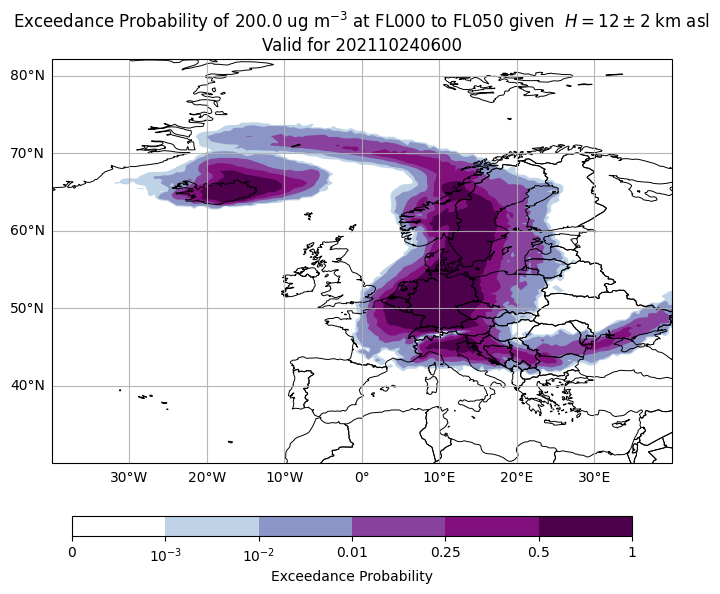

In [9]:
plot_excprobs(exc_prob_cube, threshold = 0.0002, h_km = "12 \pm 2", 
              fl_index = 0, time_index = 6)